# XGBoost Model for NLP Breast Cancer Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn import set_config
set_config(display='diagram')
import joblib
!pip install shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 6.2 MB/s eta 0:00:00


In [ ]:
data = pd.read_excel('drive/MyDrive/June/Supplementary2_V2_preprocessed.xlsx')
# Overview of columns in dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10045 entries, 0 to 10044
Data columns (total 20 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   DB_ID                                              10045 non-null  object 
 1   DISEASE                                            10042 non-null  object 
 2   DIS_CLASS                                          10045 non-null  object 
 3   GENE                                               10045 non-null  object 
 4   PUBMED.ID                                          10045 non-null  int64  
 5   LACKASSO                                           10045 non-null  object 
 6   TITLE                                              2676 non-null   object 
 7   YEAR                                               10045 non-null  int64  
 8   CONCLUSION                                         8502 non-null   object 
 9   REF_SE

## Split dataset into train and test sets

In [ ]:
# X and Y columns
data[['REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem', 'ASSOCIATION_CLASS']]

,REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem,ASSOCIATION_CLASS
0,no differ pattern lmyc rflp were found breast ...,N
1,cyp1a1 is gene cytochrom p450 famili ha propos...,A
2,howev mutat analysi ecadherin multipl foci car...,A
3,find provid no evid role comt val58met cyp1a12...,N
4,find provid no evid role comt val58met cyp1a12...,N
...,...,...
10040,purpos studi wa determin whether sipa1 c polym...,X
10041,studi sipa1 c polymorph wa detect metastat bre...,X
10042,found sipa1 c polymorph wa significantli assoc...,Y
10043,find indic metastat breast cancer patient sipa...,X


In [ ]:
X = data.drop('ASSOCIATION_CLASS', axis=1)
y = data['ASSOCIATION_CLASS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
len(X_train)

8036

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train

array([2, 2, 1, ..., 3, 3, 2])

## Grid search

In [ ]:
# Create pipeline consisting of vectorizer + classifier
pipeline = Pipeline(steps=[("vectorizer", TfidfVectorizer()),
                           ("classifier", XGBClassifier(seed=20231127, num_class=4, objective='multi:softprob', eval_metric='mlogloss'))])
pipeline

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None, num_class=4,
                               num_parallel_tree=None, ...))])

In [ ]:
# Search space of hyperparameters
param_grid={
    'vectorizer__ngram_range': [(1,1), (1,2), (1,3), (2,2), (2,3)],
    'classifier__learning_rate': np.linspace(0.05, 1, 20),
    #'classifier__gamma': np.linspace(0, 0.5, 6),
    'classifier__max_depth': np.arange(3, 8, 1),
    #'classifier__min_child_weight': np.arange(1, 5, 1),
    'classifier__n_estimators': np.arange(100, 300, 50),
    #'classifier__subsample': np.linspace(0.6, 1, 5),
    #'classifier__colsample_bytree': np.linspace(0.6, 1, 5)
}

In [ ]:
# Stratified K-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
# Perform grid search
search = RandomizedSearchCV(pipeline, param_grid, n_iter=10, scoring='f1_macro', n_jobs=-1, cv=cv, verbose=1, error_score='raise', random_state=1)
result = search.fit(X_train['REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem'], y_train)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Score: 0.7756604673295484
Best Hyperparameters: {'vectorizer__ngram_range': (1, 2), 'classifier__subsample': 0.9, 'classifier__n_estimators': 100, 'classifier__min_child_weight': 1, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.7999999999999999, 'classifier__gamma': 0.2, 'classifier__colsample_bytree': 1.0}


In [ ]:
# Best-performing model with final hyperparameters
best_model = result.best_estimator_
best_model

Pipeline(steps=[('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.55,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=150, n_jobs=None, num_class=4,
                               num_parallel_tree=None, ...))])

In [ ]:
# Save best model
joblib.dump(best_model, 'drive/MyDrive/June/XGBoost_model.pkl')

['drive/MyDrive/June/XGBoost_model.pkl']

## Performance evaluation

In [ ]:
# Load best model
best_model = joblib.load('drive/MyDrive/June/XGBoost_model.pkl')
best_model

Pipeline(steps=[('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.55,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=150, n_jobs=None, num_class=4,
                               num_parallel_tree=None, ...))])

In [ ]:
print('Distribution of true labels:')
print('Training set:')
print(pd.Series(le.inverse_transform(y_train)).value_counts())
print('Test set:')
print(y_test.value_counts())

Distribution of true labels:
Training set:
X    3915
Y    2017
A    1292
N     812
dtype: int64
Test set:
X    985
Y    490
A    328
N    206
Name: ASSOCIATION_CLASS, dtype: int64


### Get predictions and probabilities

In [ ]:
print('Training set:')
# Get the predicted probabilities for each class
y_pred_proba_train = best_model.predict_proba(X_train['REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem'])
print(y_pred_proba_train)
# The class with the highest probability becomes the prediction
y_pred_train = np.argmax(y_pred_proba_train, axis=1)
classes = best_model.classes_
# Mapping of indices (0, 1, 2, 3) to classes (A, N, X, Y)
y_pred_train = np.array([classes[i] for i in y_pred_train])
print(le.inverse_transform(y_pred_train))
print('Test set:')
y_pred_proba_test = best_model.predict_proba(X_test['REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem'])
print(y_pred_proba_test)
y_pred_test = np.argmax(y_pred_proba_test, axis=1)
y_pred_test = np.array([classes[i] for i in y_pred_test])
y_pred_test = le.inverse_transform(y_pred_test)
X_test['prediction'] = y_pred_test
# Obtain maximum predicted probability (i.e. prob of predicted class)
y_pred_max_proba_test = np.max(y_pred_proba_test, axis=1)
X_test['predicted_probability'] = y_pred_max_proba_test
print(y_pred_test)

Training set:
[[3.3043806e-02 1.9471945e-03 9.4499731e-01 2.0011660e-02]
 [4.6371777e-02 2.9166853e-02 7.5481313e-01 1.6964829e-01]
 [4.2634510e-02 5.1780862e-01 2.8406223e-02 4.1115063e-01]
 ...
 [5.7868224e-01 2.1015221e-04 2.7735952e-01 1.4374809e-01]
 [5.0451610e-02 4.9457587e-03 1.0371176e-02 9.3423146e-01]
 [8.3529595e-03 2.1305573e-03 8.8999939e-01 9.9517174e-02]]
['X' 'X' 'N' ... 'A' 'Y' 'X']
Test set:
[[0.0056265  0.0025746  0.01019951 0.9815994 ]
 [0.71273243 0.00114178 0.11895845 0.16716734]
 [0.02143494 0.00384929 0.87105066 0.10366511]
 ...
 [0.26536375 0.4523651  0.0144182  0.26785293]
 [0.02791335 0.01118621 0.24760462 0.7132958 ]
 [0.00356183 0.00467529 0.10285794 0.8889049 ]]
['Y' 'A' 'X' ... 'N' 'Y' 'Y']


### Show metrics

In [ ]:
print('Training set:')
display(pd.DataFrame(classification_report(y_train, y_pred_train, output_dict=True)).T)
print('\nTest set:')
display(pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True)).T)

Training set:


,precision,recall,f1-score,support
0,0.956731,0.924149,0.940157,1292.000000
1,0.975430,0.977833,0.976630,812.000000
2,0.945711,0.974457,0.959869,3915.000000
3,0.945876,0.909767,0.927470,2017.000000
accuracy,0.950473,0.950473,0.950473,0.950473
macro avg,0.955937,0.946551,0.951032,8036.000000
weighted avg,0.950527,0.950473,0.950262,8036.000000



Test set:


,precision,recall,f1-score,support
A,0.809061,0.762195,0.784929,328.000000
N,0.762791,0.796117,0.779097,206.000000
X,0.858556,0.881218,0.869739,985.000000
Y,0.738397,0.714286,0.726141,490.000000
accuracy,0.812344,0.812344,0.812344,0.812344
macro avg,0.792201,0.788454,0.789977,2009.000000
weighted avg,0.811348,0.812344,0.811575,2009.000000


### Confusion matrix

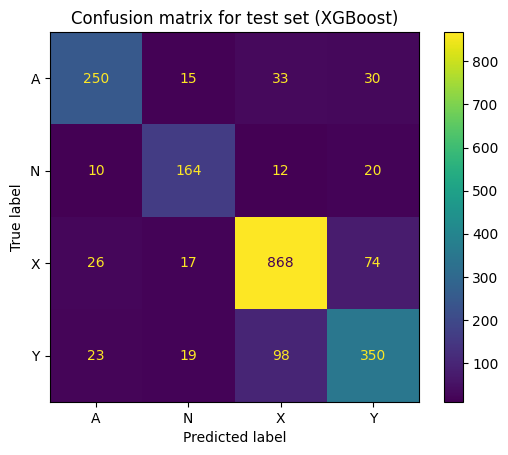

In [ ]:
# For test set
cm = confusion_matrix(y_test, y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=sorted(set(y_test))).plot()
plt.title('Confusion matrix for test set (XGBoost)')
plt.show()

### ROC curve (One-vs-Rest)

In [ ]:
# binarize the target by one-hot-encoding in a OvR fashion
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(2009, 4)

In [ ]:
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_proba_test[:, i])
    roc_auc[classes[i]] = auc(fpr[i], tpr[i])

print('ROC AUC score for each class:')
for item in roc_auc.items():
  print(item)

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(len(classes)):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= len(classes)

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

ROC AUC score for each class:
('A', 0.9531964132847752)
('N', 0.9732673160697651)
('X', 0.9547093115482235)
('Y', 0.9272776128226141)
Macro-averaged One-vs-Rest ROC AUC score:
0.95


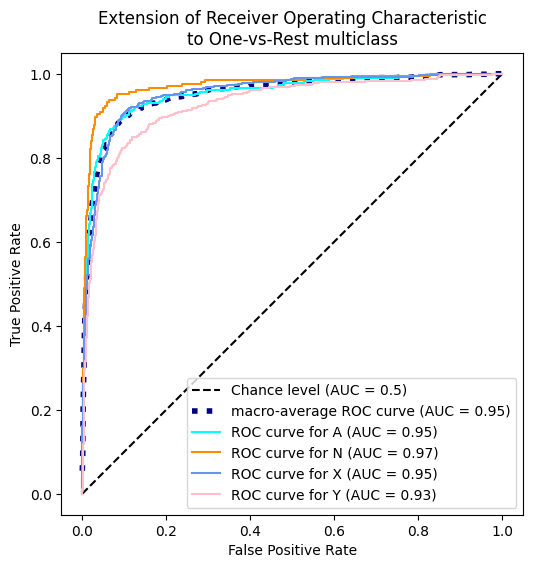

In [ ]:
# Plot ROC curve for all classes as well as macro average
fig, ax = plt.subplots(figsize=(6, 6))

plt.plot([0, 1], [0, 1], label='Chance level (AUC = 0.5)', color='black', linestyle='dashed')

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = ["aqua", "darkorange", "cornflowerblue", 'pink']
for class_id, color in zip(range(len(classes)), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred_proba_test[:, class_id],
        name=f"ROC curve for {classes[class_id]}",
        color=color,
        ax=ax
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

## Hypothesis evaluation

### Question 1: Gene classification

In [ ]:
# Count association classes for every gene
gene_class_counts = data.groupby(['REF_GENE'])['ASSOCIATION_CLASS'].value_counts().unstack()
# Get the primary class without the no-info class since it's the most frequent one
primary_class = gene_class_counts.drop('X', axis=1).idxmax(axis=1)

In [ ]:
pd.set_option('display.max_colwidth', None)
# Number of positive genes in test set
#print(len(set(X_test[y_test == 'Y']['REF_GENE'])), 'positive genes in test set')
# Genes with a primary positive association
positive_genes = gene_class_counts[primary_class == 'Y'].index
# Number of PRIMARY positive instances in test set
print(len(X_test[X_test.index.isin(y_test[y_test == 'Y'].index) & X_test['REF_GENE'].isin(positive_genes)]['REF_GENE']), 'PRIMARY positive instances in test set')
# Correctly predicted positive genes
correct_Y = X_test.loc[y_test[(y_pred_test == 'Y') & (y_test == 'Y')].index]
# PRIMARY positive instances in test set that were correctly predicted
correct_Y_primary = correct_Y[correct_Y['REF_GENE'].isin(positive_genes)]
print(len(correct_Y_primary), 'PRIMARY positive instances in test set that were correctly predicted\n')
print(correct_Y_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(correct_Y_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(correct_Y_primary['WEIGHT']))
correct_Y_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

398 PRIMARY positive instances in test set
285 PRIMARY positive instances in test set that were correctly predicted

BRCA1     19
BRCA2     14
FGFR2     10
GSTM1     10
MTHFR      8
          ..
MDM4       1
NPAS2      1
LOX        1
ERBB2      1
CLDN10     1
Name: REF_GENE, Length: 143, dtype: int64
Average predicted probability: 0.816533
Average asssociation weight: 0.6823303077052632


,REF_SENTENCE,REF_GENE,GENE_NEW,predicted_probability,WEIGHT
766,"We found that significantly increased risk of breast cancer was associated with variant genotypes in the H2AFX promoter: adjusted odds ratio [OR] = 1.80, 95% confidence interval [CI] = 1.38-2.34 for -1654AG/GG; OR = 1.40, 95% CI = 1.07-1.83 for -1420GA/AA; and OR = 1.65, 95% CI = 1.26-2.16 for -1187TC/CC. Furthermore, the number of variant alleles in the promoter haplotypes was associated with increased risks of breast cancer in a dose-response manner (OR = 6.08, 95% CI = 3.25-11.38; OR = 6.83, 95% CI = 3.83-12.18; and OR = 23.61, 95% CI = 3.95-140.99 for one, two, and three variant alleles, respectively) (P (trend) \ < 0.0001).",H2AFX,H2AFX,0.997547,0.500000
7606,"A significant association was found between carrying the CHEK2 I157T variant and increased risk of unselected breast cancer (OR = 1.48, 95% CI = 1.31-1.66, P < 0.0001), familial breast cancer (OR = 1.48, 95% CI = 1.16-1.89, P < 0.0001), and early-onset breast cancer (OR = 1.47, 95% CI = 1.29-1.66, P < 0.0001).",CHEK2,CHEK2,0.995543,0.551020
9538,"The T allele of rs9383938 in ESR1 was significantly associated with an increased breast cancer risk (OR, 1.26; 95% CI, 1.05-1.50; P = .013).",ESR1,ESR1,0.994058,0.552941
9381,Both EcoR1 (rs34214448) polymorphism of NME1 gene and rs5780218 polymorphism of KISS1 gene revealed significant association with increased risk of breast cancer development.,KISS1,KISS1,0.990679,0.666667
958,"These are the initial results concerning the prevalence of germline mutations in the ATM gene among BC cases in a Spanish population, and they suggest that ATM mutations can confer increased susceptibility to early-onset BC.",ATM,ATM,0.987329,0.535211
...,...,...,...,...,...
1783,BRCA1 and BRCA2 are two major hereditary breast cancer susceptibility genes.,BRCA2,BRCA2,0.488987,0.496667
7275,"We also identified a known breast cancer locus CASP8/ALS2CR12 associated with prostate cancer, a known cancer locus at CDKN2B-AS1 with different variants associated with lung adenocarcinoma and prostate cancer, and confirmed the associations of a breast BRCA2 locus with lung and serous ovarian cancer.",CDKN2B-AS1,CDKN2B-AS1,0.488366,1.000000
1923,This meta-analysis suggests that FGFR2 is likely an important genetic marker contributing to susceptibility of breast cancer.,FGFR2,FGFR2,0.482702,0.794118
5705,"All BRCA1 carriers and BRCA2 carriers younger than 60 had a significantly lower breast cancer risk in the Northern Netherlands; HRs were 0.66 and 0.64, respectively.",BRCA1,BRCA1,0.479574,0.484536


In [ ]:
incorrect_Y = X_test.loc[y_test[(y_pred_test != 'Y') & (y_test == 'Y')].index]
# PRIMARY positive instances in test set that were incorrectly predicted
incorrect_Y_primary = incorrect_Y[incorrect_Y['REF_GENE'].isin(positive_genes)]
print(len(incorrect_Y_primary), 'PRIMARY positive instances in test set that were incorrectly predicted\n')
print(incorrect_Y_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(incorrect_Y_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(incorrect_Y_primary['WEIGHT']))
incorrect_Y_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'prediction', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

113 PRIMARY positive instances in test set that were incorrectly predicted

BRCA2     14
BRCA1     10
TP53       7
VDR        4
GSTT1      4
          ..
MICA       1
P53BP1     1
CLCA2      1
NCoA3      1
IGF-I      1
Name: REF_GENE, Length: 62, dtype: int64
Average predicted probability: 0.69046766
Average asssociation weight: 0.6267507503008851


,REF_SENTENCE,REF_GENE,GENE_NEW,prediction,predicted_probability,WEIGHT
8078,"Association of FokI (rs2228570) and BsmI (rs1544410) single nucleotide polymorphisms (SNPs) in VDR gene with the risk of breast cancer have been investigated in several studies, however, the published data are still inconsistent.",VDR,VDR,X,0.974758,0.362069
1432,"Twenty-eight polymorphisms in eight genes of phase I (CYP1A1, CYP1A2, CYP1B1, CYP2C9, CYP2C19, CYP3A4, CYP3A5, CYP3A7) and nine genes of phase II enzymes (COMT, GSTM1, GSTM3, GSTP1, GSTT1, SULT1A1, UGT1A1, UGT1A6, UGT2B7) were genotyped... The finding regarding GSTT1 was still statistically significant after corrections for multiple comparisons. Postmenopausal breast cancer risk associated with hormone therapy may be modified by genetically determined variations in phase I and II enzymes involved in steroid hormone metabolism.",GSTT1,GSTT1,A,0.973052,0.672131
3721,The results of our investigation showed that BRCA1 mutation carriers were more likely to have ERalpha-negative breast cancer than those in the control group.,BRCA1,BRCA1,X,0.967162,0.484536
5936,"Numerous studies have investigated association between BRCA2 N372H polymorphism and risk of several cancers, especially breast cancer.",BRCA2,BRCA2,X,0.966510,0.496667
653,"The presence of at least one variant from both the methylenetetrahydrofolate reductase (MTHFR) C677T and A1298C SNPs was also associated with increased risk (OR, 2.16; 95% CI, 1.34-3.48 for 677 CT + TT/1,298 AC + CC)... Our findings indicate that genetic variation in multiple one-carbon metabolism genes may influence risk of postmenopausal breast cancer and may involve changes in methyl donor synthesis.",MTHFR,MTHFR,A,0.954779,0.508333
...,...,...,...,...,...,...
47,This study provides little evidence that variation in Val-9Ala polymorphism of MnSOD alone or through substantial interaction with key exposures believed to be pro- or anti-oxidant properties influences breast cancer risk.,MnSOD,SOD2,X,0.423802,0.235294
2464,Molecular genetic testing of BRCA1 and BRCA2 genes in high-risk women with breast/ovarian cancer is effective in determining genetic predisposition to cancer.,BRCA2,BRCA2,X,0.418137,0.496667
624,Although patients with BRCA2 germline mutations did not have a distinct histological phenotype they had an improved overall survival (100% vs 65%). Our findings suggest that there is a cluster of novel mutations in exons 10 and 11 in Greek patients with familial breast cancer.,BRCA2,BRCA2,N,0.394827,0.496667
6196,"Conclusively, our findings suggest that GSTT1 null genotype and SULT1A1 G638A AA genotype could be uselful genetic markers for breast cancer prognosis.",GSTT1,GSTT1,A,0.391793,0.672131


In [ ]:
# Number of negative genes in test set
#print(len(set(X_test[y_test == 'N']['REF_GENE'])), 'negative genes in test set')
# Genes with a primary negative association
negative_genes = gene_class_counts[primary_class == 'N'].index
# Number of PRIMARY negative instances in test set
print(len(X_test[X_test.index.isin(y_test[y_test == 'N'].index) & X_test['REF_GENE'].isin(negative_genes)]['REF_GENE']), 'PRIMARY negative instances in test set')
# Correctly predicted negative genes
correct_N = X_test.loc[y_test[(y_pred_test == 'N') & (y_test == 'N')].index]
# PRIMARY negative instances in test set that were correctly predicted
correct_N_primary = correct_N[correct_N['REF_GENE'].isin(negative_genes)]
print(len(correct_N_primary), 'PRIMARY negative instances in test set that were correctly predicted\n')
print(correct_N_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(correct_N_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(correct_N_primary['WEIGHT']))
correct_N_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

79 PRIMARY negative instances in test set
65 PRIMARY negative instances in test set that were correctly predicted

ITGB3                                       2
TLR                                         2
MTRR                                        2
TGFBR1*6A                                   2
BRIP1                                       2
LEP                                         2
SSTR1-SSTR5                                 2
GH1                                         2
BID                                         1
CRAC1                                       1
RNF146                                      1
IGHMBP2                                     1
GSTO1                                       1
SOD2                                        1
ABCB11                                      1
IL-6 -174                                   1
GEN1                                        1
ITGAv                                       1
prohibitin T                                1
POT1       

,REF_SENTENCE,REF_GENE,GENE_NEW,predicted_probability,WEIGHT
1963,"In conclusion, this meta-analysis strongly suggests that MTRR A66G polymorphism is not associated with breast cancer risk, especially in Caucasians and Asians.",MTRR,MTRR,0.991956,0.625000
2701,Further analysis of haplotypes at BARD1 also revealed no evidence that additional common genetic variation not captured by Cys557Ser was associated with breast cancer risk.,BARD1,BARD1,0.991949,0.333333
450,"We used a genetic association study design to determine if common genetic variation (frequency>or=5%) in a 400-kb region surrounding ERBB2 and containing the PPARBP, CRK7, NEUROD2, PPP1R1B, STARD3, TCAP, PNMT, CAB2, ERBB2, C17ORF37, GRB7 and ZNFN1A3 genes, was associated with breast cancer risk... We observed no association between any of the genotypes or associated haplotypes and disease risk.",NEUROD2,NEUROD2,0.991574,1.000000
453,"We used a genetic association study design to determine if common genetic variation (frequency>or=5%) in a 400-kb region surrounding ERBB2 and containing the PPARBP, CRK7, NEUROD2, PPP1R1B, STARD3, TCAP, PNMT, CAB2, ERBB2, C17ORF37, GRB7 and ZNFN1A3 genes, was associated with breast cancer risk... We observed no association between any of the genotypes or associated haplotypes and disease risk.",PPARBP,MED1,0.991574,1.000000
592,Statistical analysis indicates that there is no association of the GSTZ1 variant and hence the gene does not appear to play a significant role in the development of sporadic breast cancer.,GSTZ1,GSTZ1,0.982644,1.000000
...,...,...,...,...,...
2515,"Overall there was no association between breast cancer and NOD2 (OR = 1.1; p = 0.76), but significant associations were observed between the presence of the allele and early-onset breast cancer (OR = 1.9; p = 0.01) and between the allele and ductal breast cancer with an in situ component (OR = 2.2; p = 0.006).",NOD2,NOD2,0.521374,1.000000
8611,"Our results indicated a boardline connection between HIF-1 rs11549467 and BC risk (AG compared with GG: OR = 1.61, 95% CI = 1.05-2.49, P=0.03; AG + AA compared with GG: OR = 1.64, 95% CI = 1.08-2.51, P=0.02; AG compared with GG + AA: OR = 1.61, 95% CI = 1.04-2.48, P=0.03; OR = 1.64, 95% CI = 1.09-2.45, P=0.02), while HIF-2 rs17039192 had no influence on breast cancer.",HIF-1,SETD2,0.490660,1.000000
2874,"Therefore, our results suggest that RAD51L1 is unlikely to represent a high-penetrance breast cancer susceptibility gene.",RAD51L1,RAD51B,0.481660,0.250000
8479,"Our study suggested that RAD50 germline mutations are not associated with an increased risk of breast cancer, but patients with RAD50 germline mutations have unfavourable survival compared to patients without these mutations.",RAD50,RAD50,0.459874,0.500000


In [ ]:
incorrect_N = X_test.loc[y_test[(y_pred_test != 'N') & (y_test == 'N')].index]
# PRIMARY negative instances in test set that were incorrectly predicted
incorrect_N_primary = incorrect_N[incorrect_N['REF_GENE'].isin(negative_genes)]
print(len(incorrect_N_primary), 'PRIMARY negative instances in test set that were incorrectly predicted\n')
print(incorrect_N_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(incorrect_N_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(incorrect_N_primary['WEIGHT']))
incorrect_N_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'prediction', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

14 PRIMARY negative instances in test set that were incorrectly predicted

GNB3 825C               1
GSTO1                   1
MMP3 5A/6A              1
JAK2                    1
SHMT1                   1
MTHFR C677T             1
L-myc                   1
Li-Fraumeni syndrome    1
CYP17 MspA1             1
APEX                    1
p53--G13964C            1
PPARG                   1
RAD51L1                 1
KLLN                    1
Name: REF_GENE, dtype: int64
Average predicted probability: 0.6698223
Average asssociation weight: 0.4722537758571429


,REF_SENTENCE,REF_GENE,GENE_NEW,prediction,predicted_probability,WEIGHT
5885,This meta-analysis demonstrates that GSTO2 polymorphism may significantly increase cancer risk in Caucasian population and is associated with elevated risk of breast cancer; while GSTO1 polymorphism is not associated with cancer risk.,GSTO1,GSTO1,A,0.931670,0.666667
872,Our results suggest that CYP17 MspA1 polymorphism may be at best a weak modifier of breast cancer risk but is not a significant independent risk factor.,CYP17 MspA1,CYP17A1,A,0.873481,0.245283
2301,"We conclude that the GNB3 825C>T polymorphism does not appear to be associated with breast cancer risk, but may influence development of metastasis in low-grade tumors.",GNB3 825C,GNB3,A,0.784221,0.750000
2348,"No associations with breast cancer were observed for: APEX Q51H; XRCC1 R280H; IGFPB3 -202A>C; TGFss1 L10P, P25R, and T263I; BRCA2 N289H and T1915M; BRIP1 -64A>C; and ZNF350 (or ZBRK1) 1845C>T, L66P, R501S, and S472P... Some variants in genes within the base-excision repair pathway (XRCC1) and BRCA1 interacting proteins (BRIP1) may play a role as low penetrance breast cancer risk alleles. Previous association studies of breast cancer and BRCA2 N372H and functional observations for APEX D148E ran counter to our findings of decreased risks.",APEX,APEX1,A,0.739781,0.375000
713,"In this study, we investigated whether genetic variation in the JAK2 gene and the STAT gene region (STAT3, STAT5A and STAT5B) is associated with breast cancer (BC) risk... Haplotypes in the JAK2 gene were not associated with the risk of BC.",JAK2,JAK2,X,0.721488,0.500000
5298,"Consistent with their breast cancer associations, the C-allele of rs3817198 in LSP1 was positively associated with both adjusted dense area (P = 0.00005) and adjusted percent density (P = 0.001), whereas the A-allele of rs10483813 in RAD51L1 was inversely associated with adjusted percent density (P = 0.003), but not with adjusted dense area (P = 0.07).",RAD51L1,RAD51B,Y,0.715646,0.250000
2564,"The aim of this study was to explore a possible association between p53 codon 72, Her 2 codon 655 and MTHFR C677T polymorphisms and breast cancer in Northern Greece... A total of 42 women with breast cancer as well as healthy controls were investigated and results showed that p53 codon 72 polymorphism is statistically significantly associated with breast cancer (OR for Arg/Arg to non-Arg/Arg was 6.66, P = 0.0001 at 95% CI 2.63-16.9), but not Her 2 and MTHFR polymorphisms are associated with breast cancer (OR for Ile/Ile to non-Ile/Ile was 1.33, P = 0.54 at 95% CI 0.52-3.38 and OR for T/T versus non-T/T was 1.07, P = 0.89 at 95% CI 0.35-3.25).",MTHFR C677T,MTHFR,Y,0.708927,0.250000
2375,The MMP3 5A/6A promoter polymorphism does not appear to influence breast cancer susceptibility but may be linked to a higher risk for metastasizing among breast cancer patients.,MMP3 5A/6A,MMP3,A,0.699105,0.285714
611,"No statistically significant associations were observed for polymorphisms in PPARG, PON2, LPL, or TNF and breast cancer risk or for interactions between the polymorphisms and BMI and breast cancer risk... The findings suggest that specific polymorphisms in the PON1 and LEPR genes may play a role in progression of BBD to breast cancer among post-menopausal Caucasian women.",PPARG,PPARG,A,0.698824,0.400000
3307,"However, we observed no effect for breast cancer, a common Li-Fraumeni syndrome tumor (OR = 1.06, P = 0.57, 95% confidence interval 0.88-1.27).",Li-Fraumeni syndrome,TP53,X,0.602744,0.166667


In [ ]:
# Genes with a primary ambiguous association
ambiguous_genes = gene_class_counts[primary_class == 'A'].index
# Number of PRIMARY ambiguous instances in test set
print(len(X_test[X_test.index.isin(y_test[y_test == 'A'].index) & X_test['REF_GENE'].isin(ambiguous_genes)]['REF_GENE']), 'PRIMARY ambiguous instances in test set')
# Correctly predicted ambiguous genes
correct_A = X_test.loc[y_test[(y_pred_test == 'A') & (y_test == 'A')].index]
# PRIMARY ambiguous instances in test set that were correctly predicted
correct_A_primary = correct_A[correct_A['REF_GENE'].isin(ambiguous_genes)]
print(len(correct_A_primary), 'PRIMARY ambiguous instances in test set that were correctly predicted\n')
print(correct_A_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(correct_A_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(correct_A_primary['WEIGHT']))
correct_A_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

202 PRIMARY ambiguous instances in test set
157 PRIMARY ambiguous instances in test set that were correctly predicted

BRCA1/2    7
CYP1A1     5
XPD        4
RAD51      4
CYP1B1     4
          ..
PAI-1      1
GLO1       1
PI3K       1
USP1       1
LDLC       1
Name: REF_GENE, Length: 111, dtype: int64
Average predicted probability: 0.8099567
Average asssociation weight: 0.5736113929235669


,REF_SENTENCE,REF_GENE,GENE_NEW,predicted_probability,WEIGHT
1883,"Although larger studies are needed to validate the study results, our data suggest that amino acid substitution variants of XRCC1 and XRCC3 genes may contribute to breast cancer susceptibility.",XRCC3,XRCC3,0.988583,0.421053
4992,Our results suggest that the MDR1 C3435T polymorphism may contribute to individual susceptibility to breast cancer.,MDR1,ABCB1,0.982444,0.517241
1438,"Twenty-eight polymorphisms in eight genes of phase I (CYP1A1, CYP1A2, CYP1B1, CYP2C9, CYP2C19, CYP3A4, CYP3A5, CYP3A7) and nine genes of phase II enzymes (COMT, GSTM1, GSTM3, GSTP1, GSTT1, SULT1A1, UGT1A1, UGT1A6, UGT2B7) were genotyped... The finding regarding GSTT1 was still statistically significant after corrections for multiple comparisons. Postmenopausal breast cancer risk associated with hormone therapy may be modified by genetically determined variations in phase I and II enzymes involved in steroid hormone metabolism.",CYP3A4,CYP3A4,0.981293,0.384615
2602,"Since individuals with modified ability to metabolize these carcinogens could have a different risk for breast cancer, we investigated the role of cytochromes P-450 (CYP1A1, CYP2D6), glutathione-S-transferases (GSTM1, GSTT1, GSTP1) and N-acetyltransferases (NAT1, NAT2) gene variants in breast carcinogenesis... These data suggest that CYP1A1*4, NAT1 and NAT2 variants are involved in the susceptibility to breast carcinoma by modifying the impact of exogenous and/or endogenous exposures.",CYP2D6,CYP2D6,0.980335,0.411765
106,These findings suggest that the ADPRT Val762Ala and XRCC1 Arg399Gln polymorphisms may not play a role in the etiology of breast cancer.,ADPRT,PARP1,0.980041,0.428571
...,...,...,...,...,...
8210,"Further, the HMGCR genetic variant might be associated with risks of prostate and breast cancers but the biological mechanisms behind these findings are unclear, as the LDLC IV was not associated with these cancers.",LDLC,COG2,0.484305,0.500000
2138,These findings suggest that breast cancer patients with the TYMS 3'-UTR +6 bp/+6 bp polymorphism whose tumours show a 6 bp deletion within TYMS 3'-UTR represent a group that may derive the most benefit from 5-FU chemotherapy.,TYMS,TYMS,0.479392,0.615385
311,"Our results suggest that AGT plays a role in breast cancer risk in postmenopausal women, whereas the role of AGTR1 needs further studying.",AGTR1,AGTR1,0.468725,0.428571
96,"Thus, loss of bcl-2 expression in breast cancer is associated with a range of molecular markers of poor prognosis and may define part of an ER-negative, EGFR-positive phenotype.",bcl-2,bcl-2,0.445262,1.000000


In [ ]:
incorrect_A = X_test.loc[y_test[(y_pred_test != 'A') & (y_test == 'A')].index]
# PRIMARY ambiguous instances in test set that were incorrectly predicted
incorrect_A_primary = incorrect_A[incorrect_A['REF_GENE'].isin(ambiguous_genes)]
print(len(incorrect_A_primary), 'PRIMARY ambiguous instances in test set that were incorrectly predicted\n')
print(incorrect_A_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(incorrect_A_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(incorrect_A_primary['WEIGHT']))
incorrect_A_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'prediction', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

45 PRIMARY ambiguous instances in test set that were incorrectly predicted

RAD51                                3
KRAS                                 2
XRCC1                                2
AR                                   2
BRCA1/BRCA2                          2
XPD                                  2
CDKN2A                               2
CYP1A1                               2
BRCA1/2                              2
ADRB2                                1
COMT                                 1
PGC                                  1
CYP1A1*2C                            1
XPCs                                 1
TGF-_1                               1
NBS1                                 1
calcium-sensing receptor             1
FasL                                 1
STAT5B                               1
MDR1                                 1
CYB5A                                1
Cytochrome P450 1B1                  1
CHEK1                                1
MDR-1                      

,REF_SENTENCE,REF_GENE,GENE_NEW,prediction,predicted_probability,WEIGHT
960,We evaluated the presence of single nucleotide polymorphism (SNP) C3435T of the MDR-1 gene and its correlation with the response to primary chemotherapy using the RECIST criteria. Forty-one Brazilian women with stages II and III breast cancer using the PCR-RFLP analysis were evaluated.,MDR-1,ABCB1,X,0.975759,0.517241
1626,"MPO can be inhibited and/or upregulated by commonly used drugs; thus, our findings merit further investigation for optimization of therapeutics for breast cancer.",MPO,MPO,X,0.968873,0.500000
4635,This study analyzed the occurrences of polymorphism (SNP) in the MDR1 gene in breast cancer patients and determined a possible association with chemotherapy.,MDR1,ABCB1,X,0.968811,0.517241
4476,"We aimed to evaluate whether the hormone receptor expression, HER2 and MYC genes and their protein status, and KRAS codon 12 mutations may be prognostic or predictive biomarkers of breast cancer.",KRAS,KRAS,X,0.951360,0.444444
376,"We found no association with the MC1R variants and breast cancer risk. In conclusion, the results of this population-based study show herein that MC1R variants are associated with increased melanoma risk in the Polish population. The risk of disease seems to be increased additively for patients harbouring also the CDKN2A common variant A148T.",CDKN2A,CDKN2A,N,0.925421,0.500000
1156,"MBC appears to be biologically similar to breast cancer in females, however the phenotypic characteristics of BRCA1/2-related MBCs are not yet well elucidated.",BRCA1/2,BRCA1,N,0.911357,0.414948
1155,"MBC appears to be biologically similar to breast cancer in females, however the phenotypic characteristics of BRCA1/2-related MBCs are not yet well elucidated.",BRCA1/2,BRCA2,N,0.911357,0.373333
465,"The role of allele variants 677T and 1298C (MTHFR gene) and 2756G (MS gene) has been investigated as potentially modifying factors of BRCA gene penetrance, evaluated as age at first diagnosis of cancer, in 484 BRCA1/BRCA2 carriers and in 108 sporadic breast cancer cases as a control group... The presence of 677T allele confers an increased risk of breast cancer in BRCA1 carriers (P = 0.007) and the presence of 1298C allele confers an increased risk of breast cancer in sporadic cases (P = 0.015).",BRCA1/BRCA2,BRCA1,Y,0.900934,0.414948
239,"One of the haplotypes (TGTA - coined haplotype 3) was present in 7.3% (19/260 haplotypes) of controls (n=130) and in 16.8% (40/238 haplotypes) of high-risk breast cancer patients (n=119, P=0.001). A specific RAD51 haplotype is more prevalent among non-Ashkenazi Jewish high-risk women than in average-risk population.",RAD51,RAD51,X,0.892665,0.450980
19,"The HR (95% CI) for breast cancer was 1.24 (0.87-1.75) for COMT(Val/Met) and 1.35 (0.93-1.97) for COMT(Met/Met). No interactions with lifestyle and reproductive factors were found. The HR associated with the CYP1A1*2C Val allele was 0.80 (0.46, 1.39) with little evidence for interactions with lifestyle or reproductive factors.",CYP1A1*2C,CYP1A1,N,0.861704,0.421875


In [ ]:
# Genes with a primary noinfo association
noinfo_genes = gene_class_counts[primary_class.isna()].index
# Number of PRIMARY noinfo instances in test set
print(len(X_test[X_test.index.isin(y_test[y_test == 'X'].index) & X_test['REF_GENE'].isin(noinfo_genes)]['REF_GENE']), 'PRIMARY no-info instances in test set')
# Correctly predicted noinfo genes
correct_X = X_test.loc[y_test[(y_pred_test == 'X') & (y_test == 'X')].index]
# PRIMARY noinfo instances in test set that were correctly predicted
correct_X_primary = correct_X[correct_X['REF_GENE'].isin(noinfo_genes)]
print(len(correct_X_primary), 'PRIMARY no-info instances in test set that were correctly predicted\n')
print(correct_X_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(correct_X_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(correct_X_primary['WEIGHT']))
correct_X_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

128 PRIMARY no-info instances in test set
115 PRIMARY no-info instances in test set that were correctly predicted

CPB2                     3
CPM                      3
ATP6                     2
MRP1                     2
OS                       2
                        ..
MCL1                     1
C6orf48                  1
MAF                      1
CSMD1                    1
bile salt export pump    1
Name: REF_GENE, Length: 105, dtype: int64
Average predicted probability: 0.8363288
Average asssociation weight: 0.0


,REF_SENTENCE,REF_GENE,GENE_NEW,predicted_probability,WEIGHT
8864,"To explore correlations between body mass index (BMI), preoperative systemic immune-inflammation index (SII) and endocrine therapy resistance, and evaluate BMI and SII as predictors of resistance, in patients with luminal breast cancer.",SII,X,0.996412,0.0
8772,The aim of this study was to evaluate the prognostic potential of urokinase-type plasminogen activator (uPA) and plasminogen activator inhibitor type 1 (PAI-1) tumor tissue levels and examine the association between these biomarkers and classical prognostic factors in early node-negative luminal breast cancer patients.,plasminogen,X,0.996221,0.0
7396,Here we present the first exploratory biomarker study conducted on a cohort of 187 patients with breast cancer to evaluate the prognostic role of total GIV (tGIV) and tyrosine phosphorylated GIV (pYGIV) across the various molecular subtypes.,GIV,X,0.994820,0.0
6901,"In this study, we examined 114 paired samples (tumor and normal tissues) from breast cancer patients to study the genotype distribution and somatic mutation of the SNP in MIR 196A2 (rs11614913 C-T).",MIR,X,0.994598,0.0
6377,"The relationship between tumor messenger RNA (mRNA) expression and plasma levels of TF and TFPI (������������ and ���������������), tagging single nucleotide polymorphisms (tagSNPs) in F3 (TF) (n=6) and TFPI (n=18), and clinicopathological characteristics and molecular tumor subtypes were explored in 152 treatment naive breast cancer patients.",TF,X,0.993906,0.0
...,...,...,...,...,...
5716,"Associations with breast cancer-specific mortality differed by IA ancestry; SOCS1 rs193779, STAT3 rs1026916, and STAT4 rs11685878 associations were limited to women with low IA ancestry, and associations with JAK1 rs2780890, rs2254002, and rs310245 and STAT1 rs11887698 were observed among women with high IA ancestry.",STAT1,X,0.555284,0.0
5304,These genetic associations suggest a role for a number of pro- and anti-inflammatory genes in the development of LE following breast cancer treatment.,LE,X,0.495376,0.0
6223,"Finally, functional studies of these SNPs could provide a deeper understanding of the role that MIR17HG plays in the pathophysiology of breast cancer.",MIR17HG,X,0.488803,0.0
7930,These results suggest a mechanism for genetic variation in E1C plasma concentrations as well as possible SNP biomarkers to identify ER+ breast cancer patients for whom STS inhibitors might be of clinical value.,STS,X,0.486484,0.0


In [ ]:
incorrect_X = X_test.loc[y_test[(y_pred_test != 'X') & (y_test == 'X')].index]
# PRIMARY noinfo instances in test set that were incorrectly predicted
incorrect_X_primary = incorrect_X[incorrect_X['REF_GENE'].isin(noinfo_genes)]
print(len(incorrect_X_primary), 'PRIMARY noinfo instances in test set that were incorrectly predicted\n')
print(incorrect_X_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(incorrect_X_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(incorrect_X_primary['WEIGHT']))
incorrect_X_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'prediction', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

13 PRIMARY noinfo instances in test set that were incorrectly predicted

RCC                             1
SOCS1                           1
PLCG2                           1
TYRP1                           1
JAK1                            1
PARP                            1
BNIP3                           1
IL-21                           1
sex hormone binding globulin    1
NRG2                            1
STAT4                           1
NRBF2                           1
CI                              1
Name: REF_GENE, dtype: int64
Average predicted probability: 0.67513424
Average asssociation weight: 0.0


,REF_SENTENCE,REF_GENE,GENE_NEW,prediction,predicted_probability,WEIGHT
8301,"When all the eligible studies were pooled into this meta-analysis, there was no evidence of significant association between breast cancer risk and COMT Val158Met polymorphism in any genetic model (dominant model: odds ratio [OR] = 0.99, 95% confidence interval [CI] = 0.94-1.04, P value of heterogeneity test [P(h)] = 0.009, I(2) = 36.9%; recessive model: OR = 0.97, 95% CI = 0.92-1.02, P(h) = 0.044, I(2) = 28.6%; additive model: OR = 0.98, 95% CI = 0.91-1.05, P(h) = 0.004, I(2) = 40.4%).",CI,X,N,0.972484,0.0
8122,"Interestingly, TYRP1 might be related to breast cancer through a non-vitamin D relevant mechanism but further studies are needed.",TYRP1,X,A,0.944392,0.0
6475,"Luciferase assays did not identify SNPs that affect transactivation of ZNF365, but identified a protective haplotype in iCHAV2, associated with silencing of the NRBF2 promoter, implicating this gene in the etiology of breast cancer.",NRBF2,X,N,0.935391,0.0
9953,"Our present study established a robust association between the functional polymorphism (rs12508721C>T) in IL-21 and prognosis of breast cancer, indicating that this polymorphism may be a potential biomarker for prognosis of breast cancer.",IL-21,X,A,0.735427,0.0
6611,"Furthermore, three SNPs in PLCG2 that had previously been shown to modify the association of MHT use with breast cancer risk were found to modify also the association of MHT use with mammographic density (unadjusted P int <0.002), but solely among cases (unadjusted P int SNP���������������MHT���������������case-status <0.02).",PLCG2,X,Y,0.707372,0.0
5454,Our identification of XRCC2 as a breast cancer susceptibility gene thus increases the proportion of breast cancers that are associated with homologous recombination-DNA-repair dysfunction and Fanconi anemia and could therefore benefit from specific targeted treatments such as PARP (poly ADP ribose polymerase) inhibitors.,PARP,X,Y,0.699897,0.0
5406,"BMI showed a positive association with the methylation of extracellular superoxide dismutase (r = 0.21, p < 0.05), Ras-association (RalGDS/AF-6) domain family member 1 (RASSF1A) (r = 0.31, p < 0.001), and breast cancer type 1 susceptibility protein (r = 0.19, p < 0.05); and inverse association with methylation of BNIP3 (r = -0.48, p < 0.0001).",BNIP3,X,Y,0.669234,0.0
4843,"Multiple SNPs in FGF1, FGF2, and NRG2 significantly interacted with multiple SNPs in EGFR, ERBB2, FGFR2, and PDGFB, suggesting that breast cancer risk is dependent on the collective effects of genetic variants in other GFs.",NRG2,X,Y,0.589926,0.0
9659,"Serum urea was inversely associated with RCC in females (effect = 1.93; 95% CI: 1.24 to 3.01; p = 0.004) but exhibited null association with RCC in males, breast cancer (BRCA) in both genders and prostate cancer (PCa) in males.",RCC,X,Y,0.531495,0.0
5711,"Associations with breast cancer-specific mortality differed by IA ancestry; SOCS1 rs193779, STAT3 rs1026916, and STAT4 rs11685878 associations were limited to women with low IA ancestry, and associations with JAK1 rs2780890, rs2254002, and rs310245 and STAT1 rs11887698 were observed among women with high IA ancestry.",JAK1,X,Y,0.512288,0.0


### Question 2: Explainability

In [ ]:
explainer = shap.TreeExplainer(best_model['classifier'])

[03:10:47] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [ ]:
vectorized = best_model['vectorizer'].transform(X_test["REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem"])
shap_values = explainer.shap_values(vectorized, check_additivity=True)

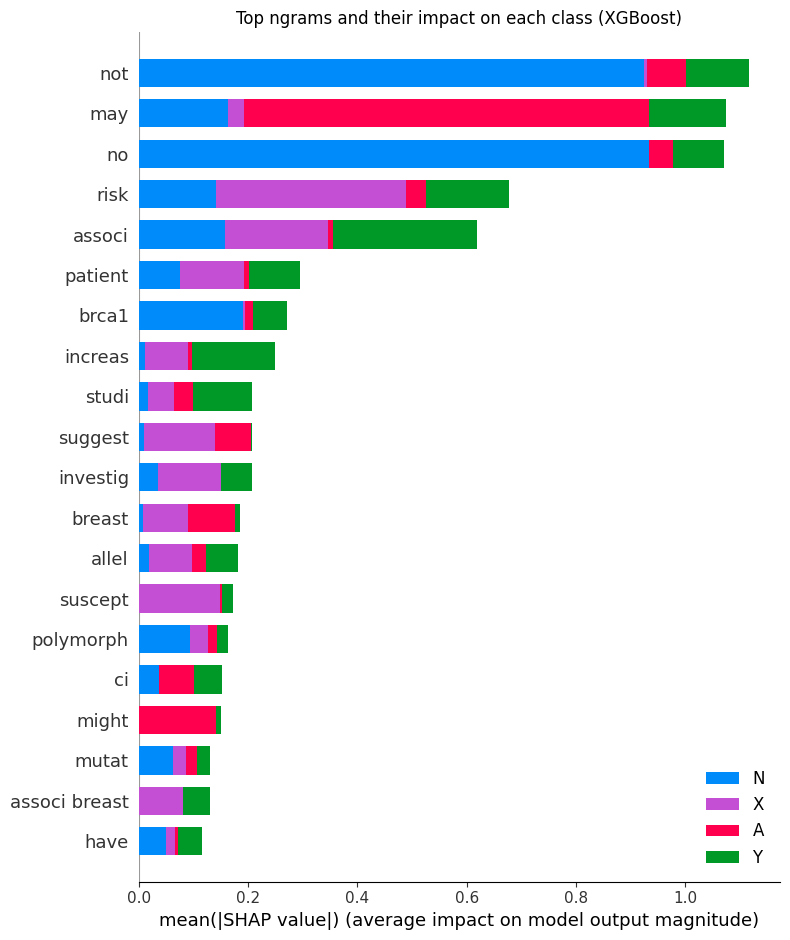

In [ ]:
feats = best_model['vectorizer'].get_feature_names_out()
vectorized_df = pd.DataFrame(vectorized.toarray(), columns = feats)
plt.title('Top ngrams and their impact on each class (XGBoost)')
shap.summary_plot(shap_values, vectorized_df, class_names=['A', 'N', 'X', 'Y'], feature_names=feats)

### Predicting on sentences that mention genes with multiple associations

In [ ]:
# Sentences that mention multiple kinds of gene associations
multiple_associations = data.groupby(['REF_SENTENCE'])['ASSOCIATION_CLASS'].nunique().gt(1)
X_test_multiple_association = X_test.loc[X_test['REF_SENTENCE'].isin(multiple_associations[multiple_associations].index)]
y_test_multiple_association = y_test[y_test.index.isin(X_test.loc[X_test['REF_SENTENCE'].isin(multiple_associations[multiple_associations].index)].index)]
combined_multiple = pd.concat([X_test_multiple_association, y_test_multiple_association], axis=1)
combined_multiple[['REF_SENTENCE', 'ASSOCIATION_CLASS', 'prediction', 'REF_GENE']].sort_values(by=['REF_SENTENCE'])

,REF_SENTENCE,ASSOCIATION_CLASS,prediction,REF_GENE
837,A case (n=250)-control (n=500) study was under...,Y,A,TGFbeta1
833,A case (n=250)-control (n=500) study was under...,A,A,GSTP1
1672,"A cohort of 1,665 adult, female mutation carri...",N,N,IRS1
7802,A matched pairs study was carried out to ascer...,X,X,leptin
7890,"After exclusion of BRCA1, BRCA2, and syndromic...",X,Y,BARD1
...,...,...,...,...
2737,While BRCA1 and BRCA2 have taken center stage ...,X,Y,BRCA1
3094,With the known interaction of BRCA1 and IGF si...,A,A,AKT
9223,Younger age at first breast cancer diagnosis w...,Y,Y,BRCA1
211,the results from our study suggest that the Ah...,N,A,CYP1A2*1F


In [ ]:
combined_multiple[combined_multiple['ASSOCIATION_CLASS'] != combined_multiple['prediction']][['REF_SENTENCE', 'ASSOCIATION_CLASS', 'prediction', 'REF_GENE']].sort_values(by=['REF_SENTENCE'])

,REF_SENTENCE,ASSOCIATION_CLASS,prediction,REF_GENE
837,A case (n=250)-control (n=500) study was under...,Y,A,TGFbeta1
7890,"After exclusion of BRCA1, BRCA2, and syndromic...",X,Y,BARD1
12,Although polymorphisms within the IL1 gene clu...,Y,N,IL6
6196,"Conclusively, our findings suggest that GSTT1 ...",Y,A,GSTT1
5298,Consistent with their breast cancer associatio...,N,Y,RAD51L1
2680,Data on the association between the AR repeat ...,A,X,AR
6535,Haplotype analysis showed that FTO TAC haploty...,X,Y,TGC
9379,"Here, we analyzed the association of EcoR1 (rs...",X,Y,KISS1
8909,"However, no statistical significant difference...",N,X,HLA-G
7301,"In HMGB1 gene, haplotype analysis did not reve...",Y,N,RAGE


In [ ]:
len(combined_multiple[combined_multiple['ASSOCIATION_CLASS'] != combined_multiple['prediction']][['REF_SENTENCE', 'ASSOCIATION_CLASS', 'prediction', 'REF_GENE']].sort_values(by=['REF_SENTENCE']))

53